In [ ]:
# https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train
# https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trav15","key":"e495463dd3e18b68fd8bc994411dea65"}'}

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import copy
import random
import time
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import h5py
from glob import glob 
%matplotlib inline

from sklearn.model_selection import train_test_split


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
! pip install -q kaggle

! pip install --upgrade --force-reinstall --no-deps kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c histopathologic-cancer-detection

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=3d14d615b55ff864179adc25d19db5966f2412c62b0332b50fad8b6790d1fe69
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 6.31G/6.31G [02:10<00:00, 28.2MB/s]
100% 6.31G/6.31G [02:10<00:00, 51.8MB/s]


In [ ]:
import zipfile

myzip = zipfile.ZipFile('histopathologic-cancer-detection.zip')

myzip.extractall()

# **Task 1 Part 1**

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'
train_labels = pd.read_csv('/content/train_labels.csv')

train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)
print(train_labels.shape)


220025 57458
(220025, 2)


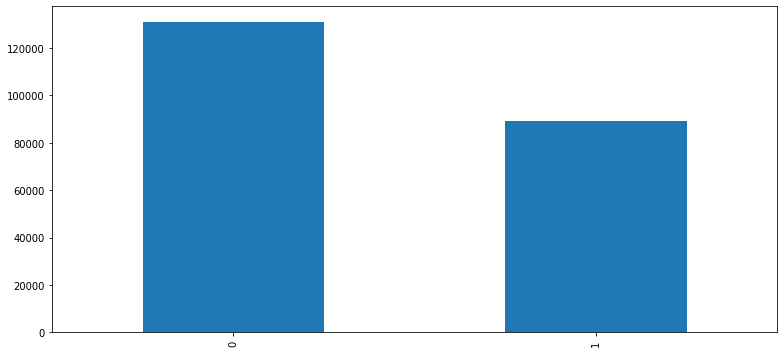

In [ ]:
plt.figure(figsize=(13, 6))
train_labels['label'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# get the ids of cancer cases
cancer = train_labels.loc[train_labels['label']==1]['id'].to_numpy() 

# get the ids of the normal cases
normal = train_labels.loc[train_labels['label']==0]['id'].to_numpy()

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)

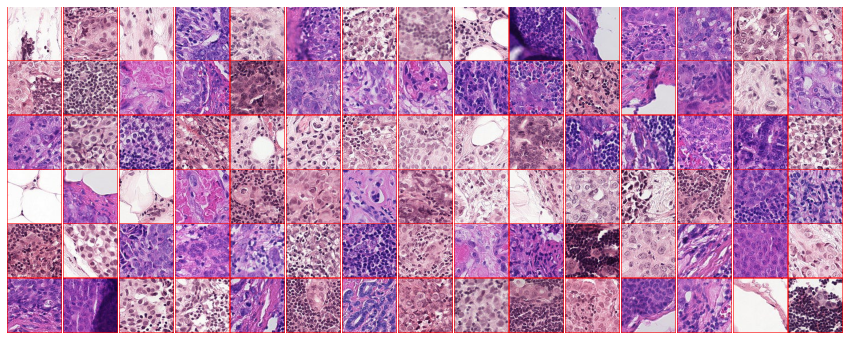

In [ ]:
# Visualize cancer cases

nrows, ncols= 6, 15
plt.subplots_adjust(wspace=0, hspace=0) 

for i, image_id in enumerate(cancer[: nrows * ncols]):
    img_path = os.path.join(train_dir , image_id +'.tif')
    img = Image.open(img_path)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

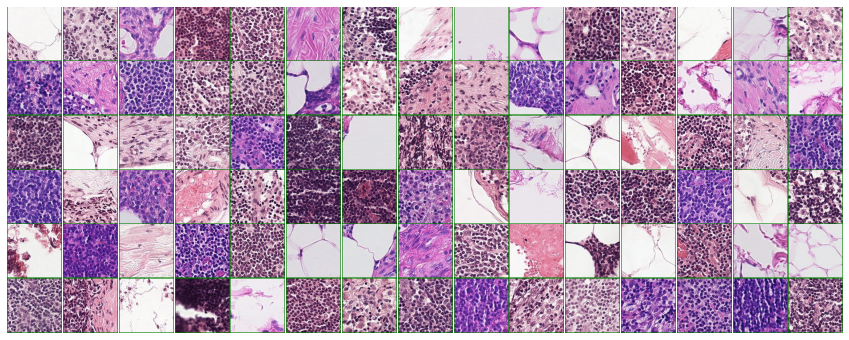

In [ ]:
# Visualize Normal Cases

nrows, ncols= 6, 15
plt.subplots_adjust(wspace=0, hspace=0) 

for i, image_id in enumerate(normal[: nrows * ncols]):
    img_path = os.path.join(train_dir , image_id +'.tif')
    img = Image.open(img_path)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='green')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

In [ ]:
# https://www.tensorflow.org/tutorials/images/cnn

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
df_data = pd.read_csv('/content/train_labels.csv')
# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df_data.shape)


IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000       

(220025, 2)


In [ ]:
from sklearn.utils import shuffle

# Create the Train and Validation Sets

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [ ]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [ ]:


base_dir='base_dir'
if not os.path.exists(base_dir):
  os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
if not os.path.exists(val_dir):
  os.mkdir(val_dir)


# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
  os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
  os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
  os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
  os.mkdir(has_tumor_tissue)



In [ ]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [ ]:
# https://www.kaggle.com/akarshu121/cancer-detection-with-cnn-for-beginners
import shutil

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('/content/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('/content/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/content/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
earlystop = EarlyStopping(monitor='loss', patience=2)                             
callbacks_list = [checkpoint, reduce_lr,earlystop]


history = model.fit(train_gen, steps_per_epoch=train_steps/10, 
                    validation_data=val_gen,
                    validation_steps=val_steps/10,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
1440/1440 [==============================] - 333s 231ms/step - loss: 0.5585 - accuracy: 0.7141 - val_loss: 0.4657 - val_accuracy: 0.7806
Epoch 2/10
1440/1440 [==============================] - 333s 231ms/step - loss: 0.4955 - accuracy: 0.7739 - val_loss: 0.4671 - val_accuracy: 0.8019
Epoch 3/10
1440/1440 [==============================] - 333s 231ms/step - loss: 0.4777 - accuracy: 0.7851 - val_loss: 0.4151 - val_accuracy: 0.8181
Epoch 4/10
1440/1440 [==============================] - 328s 227ms/step - loss: 0.4530 - accuracy: 0.7989 - val_loss: 0.4330 - val_accuracy: 0.7887
Epoch 5/10
1440/1440 [==============================] - 325s 226ms/step - loss: 0.4286 - accuracy: 0.8094 - val_loss: 0.3850 - val_accuracy: 0.8306
Epoch 6/10
1440/1440 [==============================] - 322s 224ms/step - loss: 0.4159 - accuracy: 0.8188 - val_loss: 0.4049 - val_accuracy: 0.8163
Epoch 7/10
1440/1440 [==============================] - 324s 225ms/step - loss: 0.3914 - accuracy: 0.8294 - val_

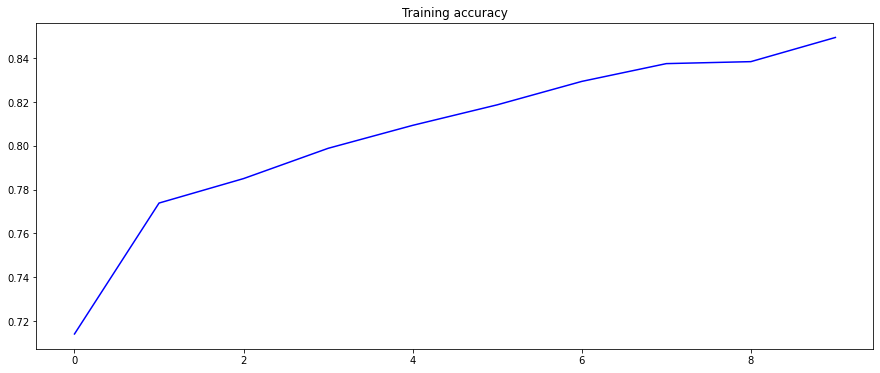

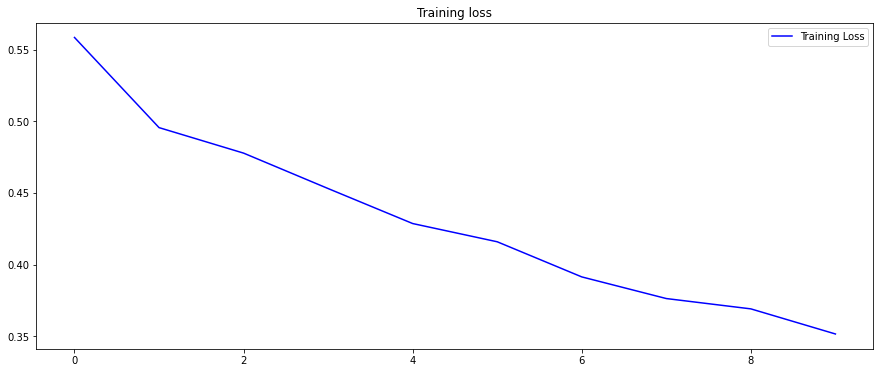

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

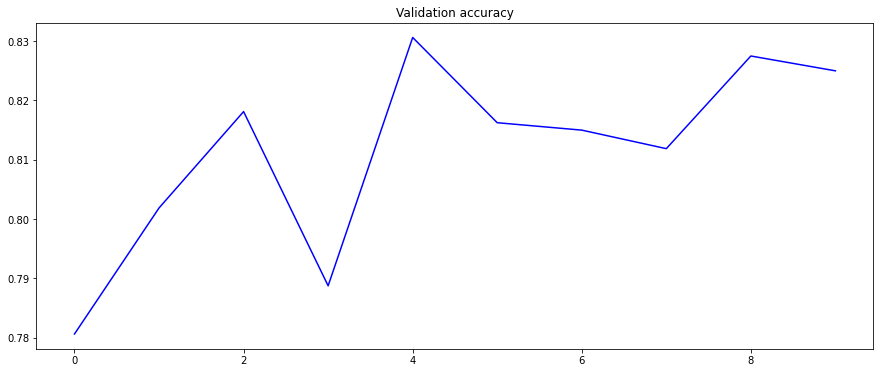

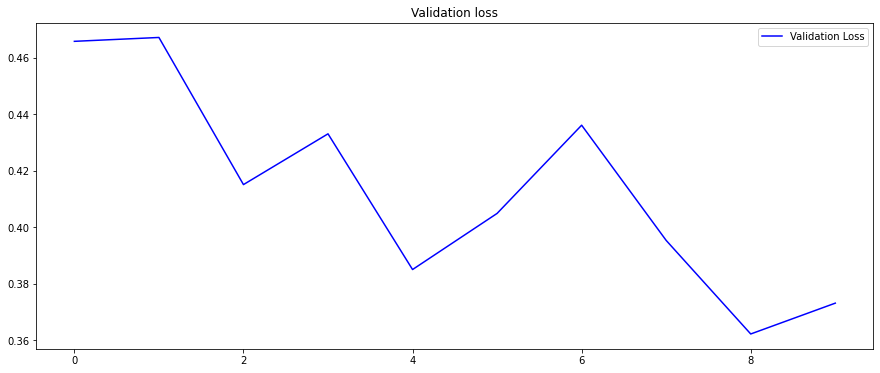

In [ ]:
acc = history.history['val_accuracy']
loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Validation accuracy')
plt.title('Validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Validation Loss')
plt.title('Validation loss')
plt.legend()

plt.show()

### This was a pretty tricky implementation to run. For this task I wanted to use a difficult and long dataset to understand, and not just one of the built in tensorflow and keras datasets. So I decided to go with a Kaggle dataset, more specifically the hispathologic cancer dataset (https://www.kaggle.com/c/histopathologic-cancer-detection/data). This dataset is a collection of pathology scanned images of tissues with or without tumors. Due to the sheer size of the dataset I actually had to transfer over to using Google colab and downloading the dataset directly from Kaggle using the API command. And even then transferring the data, separating it into training and testing data, and then making the process of turning it into trainable data for a model was pretty long. 

### As for the architecture of the model, I went with a pretty standard concolution model with a series of MaxPooling, Conv2D, Dropout, and Dense layers. I actually went with as many as I could before getting errors, then scaled down the number of layers to see if there were any differences in performance. It honestly worked better with more layers than less but not by much. For example using two layers of Conv2D and MaxPooling each got me a training accuracy of 83% while the maximum gives me 84%, so really there's not that much difference. I tried to work with other layers but that either caused errors or poorer results so I just continued with the MaxPooling and Conv2D layers. 

### And to track and show the results I used the model.fit method to perform the training and record the entire results in a 'history' variable which I then used in order to show these results in a matplotlib line graph showing the relation between the loss and accuracy values with the epochs of each training cycle.

# **Task 1 Part 2**

In [ ]:
# https://introduction-to-inferentia.workshop.aws/resnet50/12_run_on_cpu.html
# https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
# https://www.kaggle.com/gaborfodor/resnet50-example
import tensorflow.compat.v1.keras as keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.preprocessing import image

# Instantiate Keras ResNet50 model
keras.backend.set_learning_phase(0)
tf.keras.backend.set_image_data_format('channels_last')

/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
# https://www.kaggle.com/igorslima/resnet50-cancer
# https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (96,96,3))
'''
model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
#x = MaxPooling2D((2,2), padding='same')(x)
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation = "softmax"))

model.summary()
'''

model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation = "softmax"))

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 32)          589856    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         73856     
_________________________________________________________

In [ ]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath = "res_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
earlystop = EarlyStopping(monitor='loss', patience=2)                             
callbacks_list = [checkpoint, reduce_lr,earlystop]


history = model.fit(train_gen, steps_per_epoch=train_steps/10, 
                    validation_data=val_gen,
                    validation_steps=val_steps/10,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1440/1440 [==============================] - 621s 428ms/step - loss: 0.6909 - accuracy: 0.5088 - val_loss: 0.6887 - val_accuracy: 0.5400
Epoch 2/10
1440/1440 [==============================] - 637s 442ms/step - loss: 0.6114 - accuracy: 0.6738 - val_loss: 0.5747 - val_accuracy: 0.7131
Epoch 3/10
1440/1440 [==============================] - 607s 422ms/step - loss: 0.5772 - accuracy: 0.7060 - val_loss: 0.5616 - val_accuracy: 0.7181
Epoch 4/10
1440/1440 [==============================] - 595s 413ms/step - loss: 0.5627 - accuracy: 0.7214 - val_loss: 0.5254 - val_accuracy: 0.7431
Epoch 5/10
1440/1440 [==============================] - 585s 406ms/step - loss: 0.5596 - accuracy: 0.7210 - val_loss: 0.5640 - val_accuracy: 0.7144
Epoch 6/10
1440/1440 [==============================] - 588s 408ms/step - loss: 0.5515 - accuracy: 0.7253 - val_loss: 0.5727 - val_accuracy: 0.7281
Epoch 7/10
1440/1440 [==============================] - 589s 409ms/step - loss: 0.5421 - accuracy: 0.7337 - val_

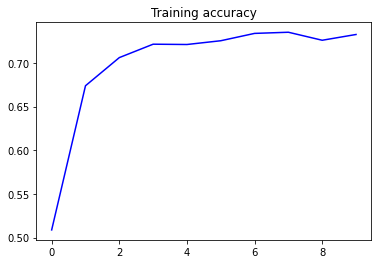

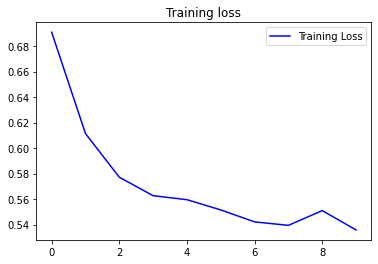

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

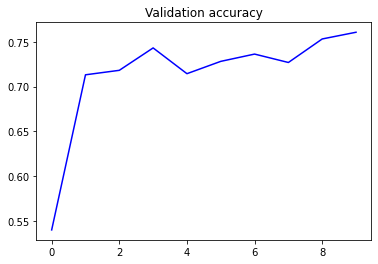

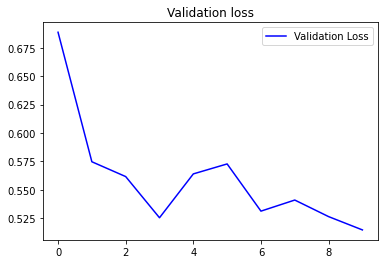

In [ ]:
acc = history.history['val_accuracy']
loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Validation accuracy')
plt.title('Validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Validation Loss')
plt.title('Validation loss')
plt.legend()

plt.show()

### For this task the model I went with was a ResNet50 model. It's pretty tricky to say whether this model did better or worse than the model in part 1. For one thing while the total training and validation accuracy and loss values didn't come close to those in part 1 it does seem to at least have a better process for doing these values as for example in part 1 the training accuracy went from around 72 to 84 showing a 12% increase, this model's training accuracy went from around 50 all the way to 70, a 20% increase. This can also be seen in the validation results whereas part 1 had some pretty erratic results, part 2 had more consistency.

### These differences in results may have had to do with how I had to structure the models for each part as I actually had to add some arguments to part 2's model layers in order to make them function as closelsy as possible to the same model structure as part 1.

#**Task 1 Part 3**

In [ ]:
# https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]



available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}
for i in range(len(train_gen)):
  index = random.randint(0,len(train_gen[i][0])-1)
  image = train_gen[i][0][index]
  num_transformations_to_apply = random.randint(1, len(available_transformations))
  num_transformations = 0
  transformed_image = None
  while num_transformations <= num_transformations_to_apply:
      # choose a random transformation to apply for a single image
      key = random.choice(list(available_transformations))
      transformed_image = available_transformations[key](image)
      image = transformed_image
      num_transformations += 1
  train_gen[i][0][index] = image

In [ ]:
for i in range(len(val_gen)):
  index = random.randint(0,len(val_gen[i][0])-1)
  image = val_gen[i][0][index]
  num_transformations_to_apply = random.randint(1, len(available_transformations))
  num_transformations = 0
  transformed_image = None
  while num_transformations <= num_transformations_to_apply:
      # choose a random transformation to apply for a single image
      key = random.choice(list(available_transformations))
      transformed_image = available_transformations[key](image)
      image = transformed_image
      num_transformations += 1
  val_gen[i][0][index] = image

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filepath = "aug_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
earlystop = EarlyStopping(monitor='loss', patience=2)                             
callbacks_list = [checkpoint, reduce_lr,earlystop]


history = model.fit(train_gen, steps_per_epoch=train_steps/10, 
                    validation_data=val_gen,
                    validation_steps=val_steps/10,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
1440/1440 [==============================] - 342s 237ms/step - loss: 0.5521 - accuracy: 0.7285 - val_loss: 0.5135 - val_accuracy: 0.7688
Epoch 2/10
1440/1440 [==============================] - 342s 238ms/step - loss: 0.4986 - accuracy: 0.7711 - val_loss: 0.4841 - val_accuracy: 0.7819
Epoch 3/10
1440/1440 [==============================] - 357s 248ms/step - loss: 0.4760 - accuracy: 0.7835 - val_loss: 0.4863 - val_accuracy: 0.7769
Epoch 4/10
1440/1440 [==============================] - 357s 248ms/step - loss: 0.4602 - accuracy: 0.7935 - val_loss: 0.4344 - val_accuracy: 0.7944
Epoch 5/10
1440/1440 [==============================] - 351s 244ms/step - loss: 0.4369 - accuracy: 0.8047 - val_loss: 0.4626 - val_accuracy: 0.8012
Epoch 6/10
1440/1440 [==============================] - 355s 247ms/step - loss: 0.4237 - accuracy: 0.8141 - val_loss: 0.3837 - val_accuracy: 0.8256
Epoch 7/10
1440/1440 [==============================] - 356s 247ms/step - loss: 0.3963 - accuracy: 0.8279 - val_

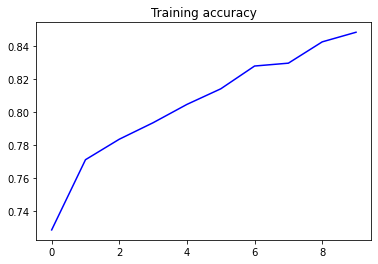

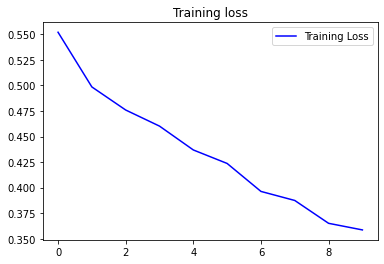

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

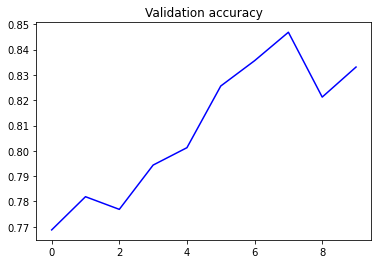

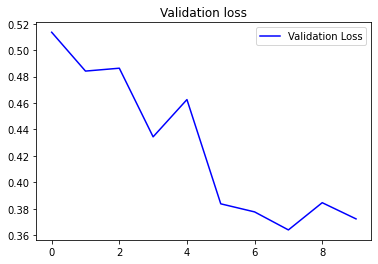

In [ ]:
acc = history.history['val_accuracy']
loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Validation accuracy')
plt.title('Validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Validation Loss')
plt.title('Validation loss')
plt.legend()

plt.show()

### Compared to the results from part 1, the results from the augmented data do not seem all that different. When it comes to the training data results there is practically no difference in the behavior. For the validation data though, there actually is some difference. At the ending of part 1's validation accuracy it seems like the accuracy was going to continue decreasing which is never a good sign. But, with part 3's validation accuracy, while it does reach 85 and for some reason drop down, it does show signs at the end of going back to increasing meaning that it may have the better performance in validation. The same concept can also be said for the validation loss value comparison as well.

# **Task 2 Part 1**

In [ ]:
# !pip install tensorflow-probability


In [19]:
from IPython import display

import imageio
import PIL
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

In [20]:
# preprocess images
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()
train_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_images])
test_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images])

def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [21]:
train_size = 50000
batch_size = 32
test_size = 10000

In [22]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [23]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [24]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    
    loss = compute_loss(model, x)
  
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [26]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [27]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 20, Test set ELBO: -483.09832763671875, time elapse for current epoch: 90.3044593334198


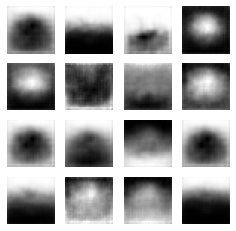

In [ ]:
generate_and_save_images(model, 0, test_sample)
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 287.5, 287.5, -0.5)

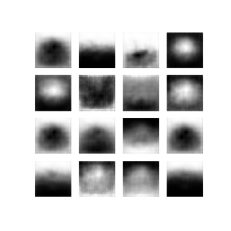

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

# **Task 2 Part 2**

In [30]:
# preprocess images
(train_images, _), (train_labels, _) = tf.keras.datasets.cifar10.load_data()
train_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_images])
train_labels = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_labels])

train_images = train_images.reshape(train_images.shape[0], 32, 32, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [31]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [32]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (6, 6), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (6, 6), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (6, 6), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

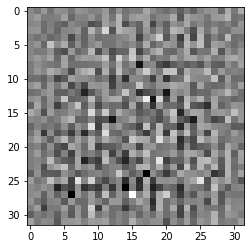

In [34]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [35]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (6, 6), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (6, 6), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00158216]], shape=(1, 1), dtype=float32)


In [37]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [42]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [43]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [44]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [45]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

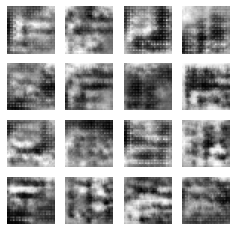

In [46]:
# After 20 epochs
train(train_dataset, EPOCHS)